# Switzerland vs Japan Network Comparison

This notebook compares the topological properties and robustness of the Swiss and Japanese transportation networks.

**Sections:**
1. **Data Loading**: Load graphs and initialize analyzers.
2. **Basic Metrics**: Comparison of nodes, edges, density, clustering, etc. (Bar Charts)
3. **Advanced Metrics**: Degree distributions (Box Plots & Histograms).
4. **Robustness Analysis**: Side-by-side comparison of attack simulations (Interactive).
5. **Visual Comparison**: Side-by-side network maps (Interactive).

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..') 
sys.path.append('.')

import pickle
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from ipywidgets import HBox, VBox, Label, Layout, HTML
from IPython.display import display
from pathlib import Path

from src.analysis.metrics import NetworkAnalyzer
from src.analysis.storage import ResultsManager
from src.analysis.visualizer import NetworkVisualizer
from src.analysis.config import AnalysisConfig

DEBUG: LOADING SRC.ANALYSIS.METRICS MODULE


## 1. Data Loading

In [2]:
# Config
COUNTRIES = ['switzerland', 'japan']
analyzers = {}
graphs = {}

for country in COUNTRIES:
    path = AnalysisConfig.get_graph_path(country)
    if not Path(path).exists():
        raise FileNotFoundError(f"Graph for {country} not found at {path}")
        
    print(f"Loading {country.title()} graph from {path}...")
    with open(path, 'rb') as f:
        G = pickle.load(f)
        graphs[country] = G
        analyzers[country] = NetworkAnalyzer(G)

storage = ResultsManager()
viz = NetworkVisualizer()

Loading Switzerland graph from datasets/switzerland/swiss_rail_network_unified.gpickle...


Loading Japan graph from datasets/japan/japan_rail_network.gpickle...


NetworkVisualizer: CI environment detected. Interactive plots will be skipped to prevent build failures.


## 2. Basic Metrics Comparison

[global_metrics] Using cached results.
[global_metrics] Using cached results.


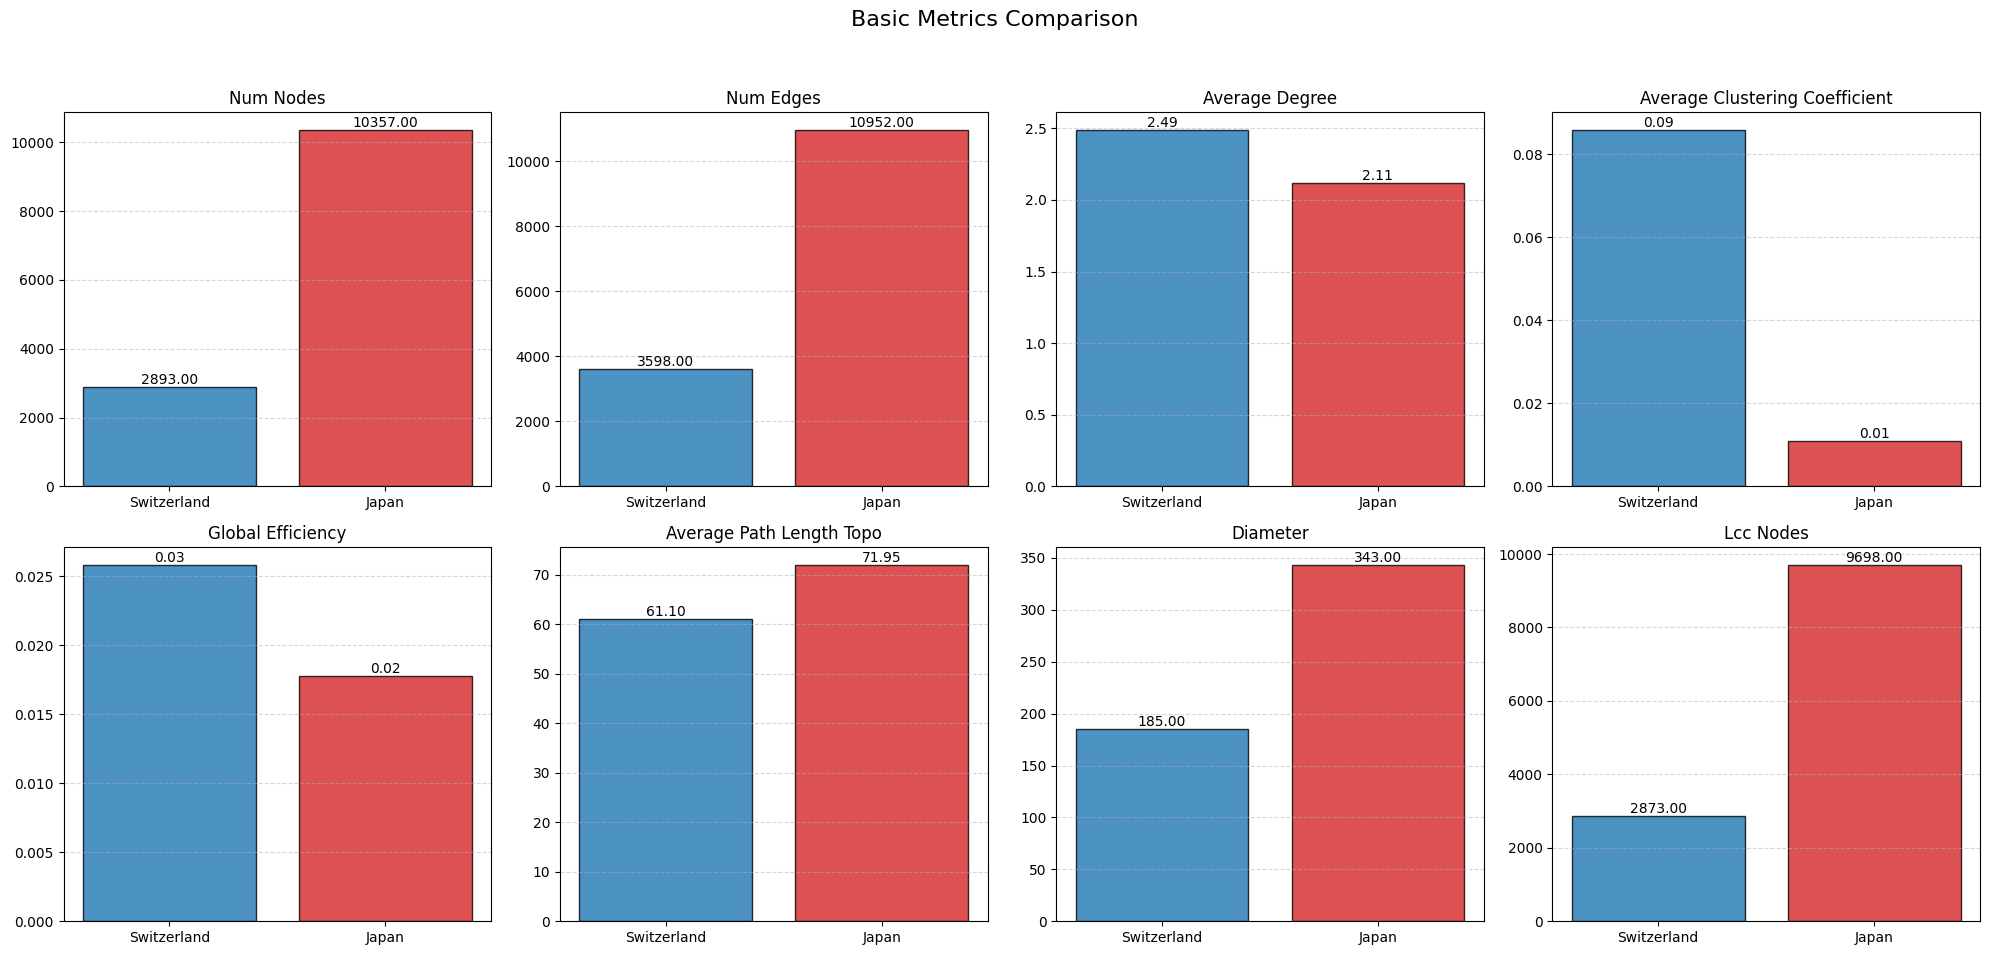

In [3]:
metrics_data = []

for country in COUNTRIES:
    m = storage.get_cached_or_run(
        country,
        "global_metrics",
        lambda c=country: analyzers[c].calculate_global_metrics()
    )
    m['Country'] = country.title()
    metrics_data.append(m)

df_metrics = pd.DataFrame(metrics_data)

# Bar Chart Visualization
# Select metrics to visualize
plot_metrics = ['num_nodes', 'num_edges', 'average_degree', 'average_clustering_coefficient', 
                'global_efficiency', 'average_path_length_topo', 'diameter', 'lcc_nodes']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Basic Metrics Comparison', fontsize=16)
axes = axes.flatten()

colors = ['#1f77b4', '#d62728'] # Blue for Switz, Red for Japan (matching flags roughly or generic)

for i, metric in enumerate(plot_metrics):
    ax = axes[i]
    # Extract values
    values = df_metrics[metric].values
    countries = df_metrics['Country'].values
    
    bars = ax.bar(countries, values, color=colors, alpha=0.8, edgecolor='black')
    ax.set_title(metric.replace('_', ' ').title())
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, 
                f'{height:.2f}', 
                ha='center', va='bottom')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## 3. Advanced Metrics Comparison

/tmp/ipykernel_2246/1063828843.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(degree_data, labels=[c.title() for c in COUNTRIES], vert=True, patch_artist=True)


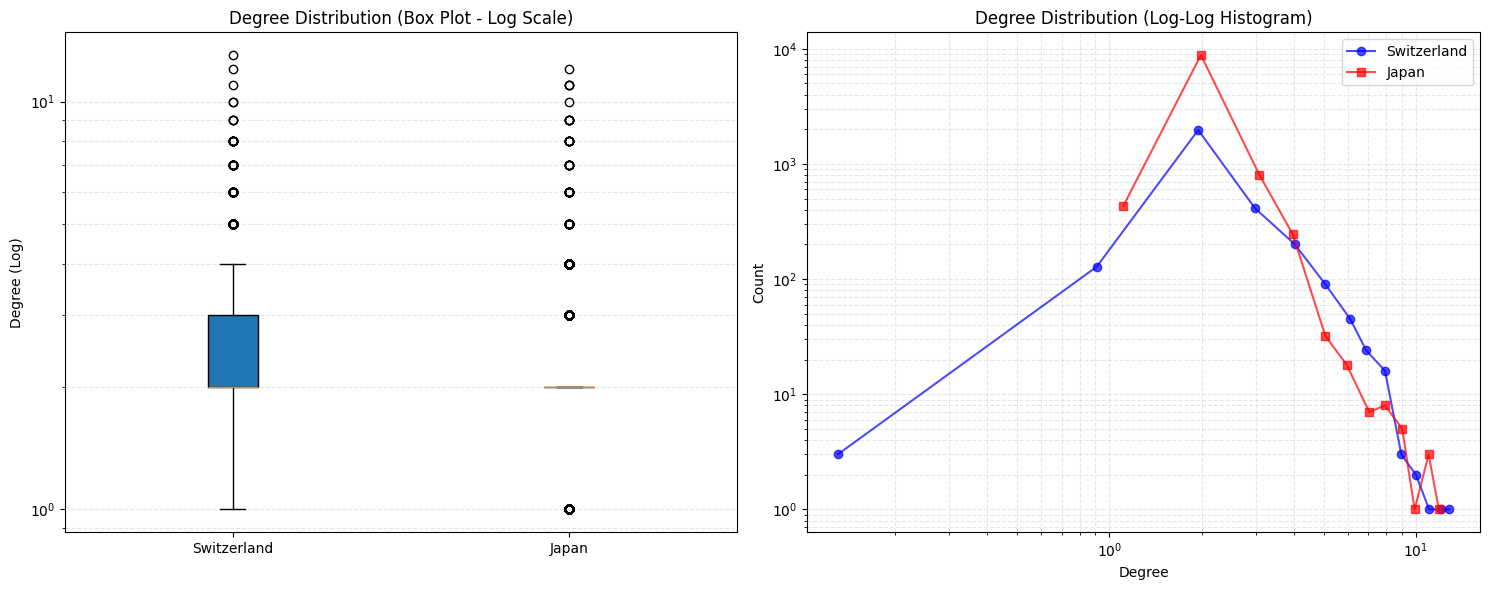

In [4]:
# Degree Analysis: Box Plot & Distribution
plt.figure(figsize=(15, 6))

degree_data = [ [d for n, d in graphs[c].degree()] for c in COUNTRIES ]

# 1. Box Plot (Log Scale)
plt.subplot(1, 2, 1)
plt.boxplot(degree_data, labels=[c.title() for c in COUNTRIES], vert=True, patch_artist=True)
plt.yscale('log')
plt.title('Degree Distribution (Box Plot - Log Scale)')
plt.ylabel('Degree (Log)')
plt.grid(True, axis='y', which='both', linestyle='--', alpha=0.3)

# 2. Degree Histogram (Log-Log)
plt.subplot(1, 2, 2)

colors_map = {'switzerland': 'blue', 'japan': 'red'}
markers = {'switzerland': 'o', 'japan': 's'}

for country in COUNTRIES:
    degrees = [d for n, d in graphs[country].degree()]
    # Binning for Log-Log plot
    y, x = np.histogram(degrees, bins=50)
    x_centers = (x[:-1] + x[1:]) / 2
    
    mask = y > 0
    plt.loglog(x_centers[mask], y[mask], marker=markers[country], linestyle='-', 
               label=country.title(), color=colors_map[country], alpha=0.7)

plt.title("Degree Distribution (Log-Log Histogram)")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Robustness Analysis Comparison


--- Robustness: Global Efficiency ---
NetworkVisualizer: CI environment detected. Generating static plot for GitHub compatibility.


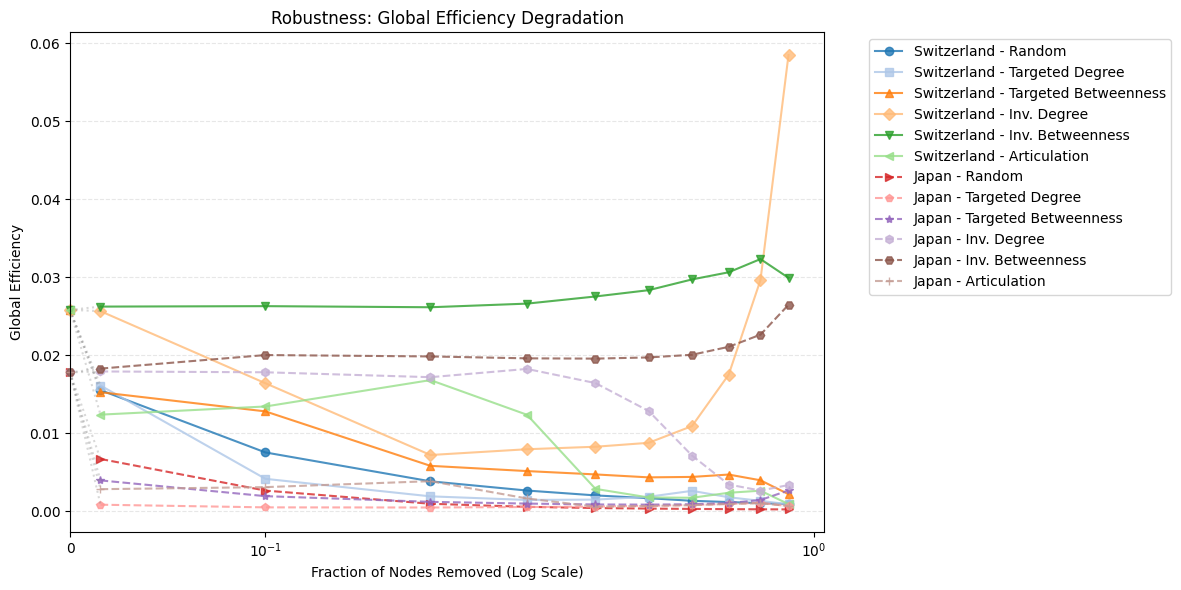


--- Robustness: LCC Size ---
NetworkVisualizer: CI environment detected. Generating static plot for GitHub compatibility.


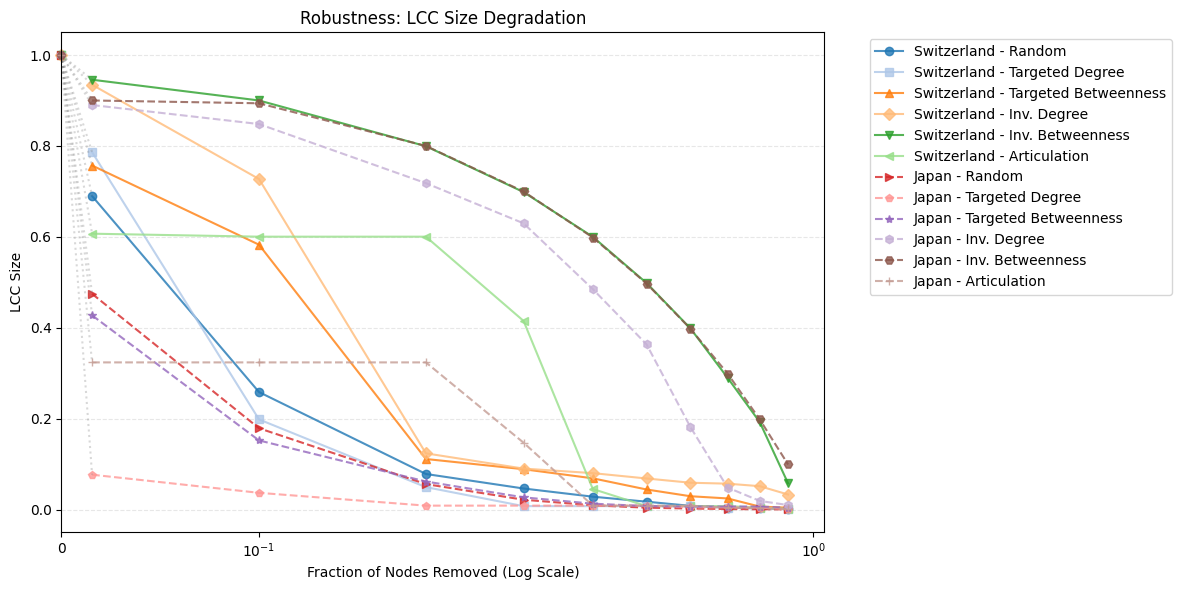


--- Robustness: Average Degree ---
NetworkVisualizer: CI environment detected. Generating static plot for GitHub compatibility.


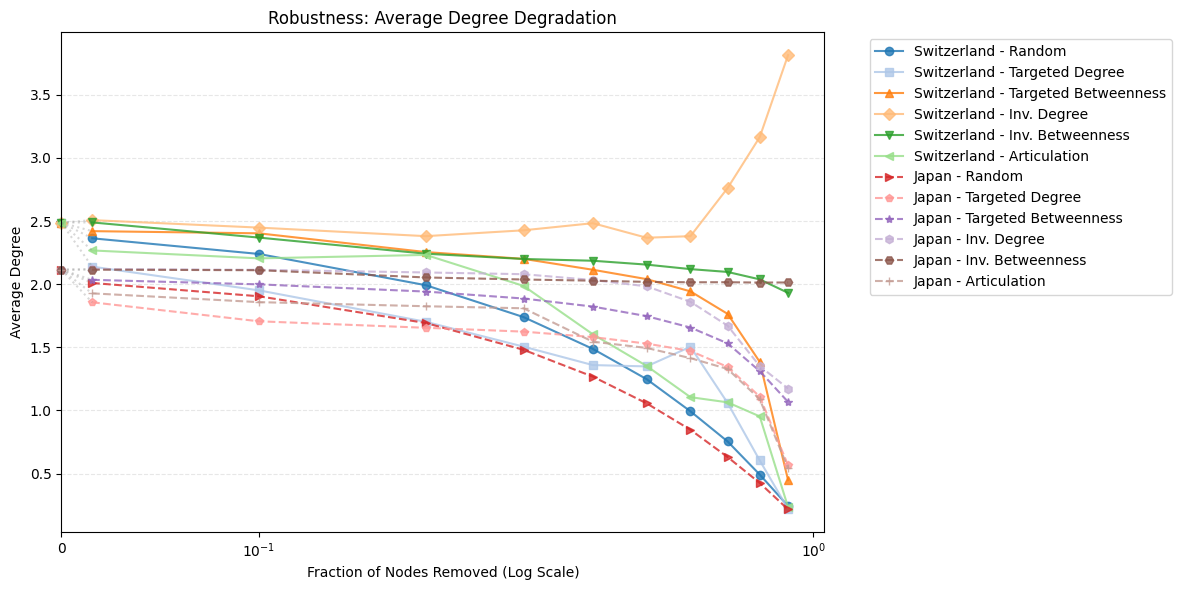


--- Robustness: Avg Clustering Coeff. ---
NetworkVisualizer: CI environment detected. Generating static plot for GitHub compatibility.


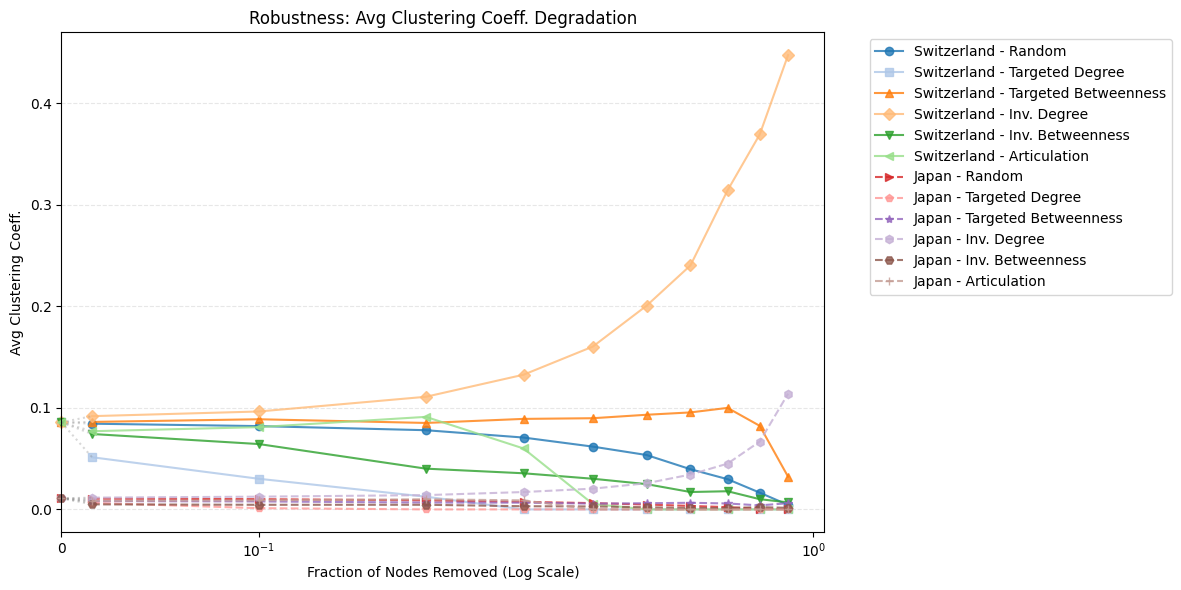


--- Robustness: Diameter ---
NetworkVisualizer: CI environment detected. Generating static plot for GitHub compatibility.


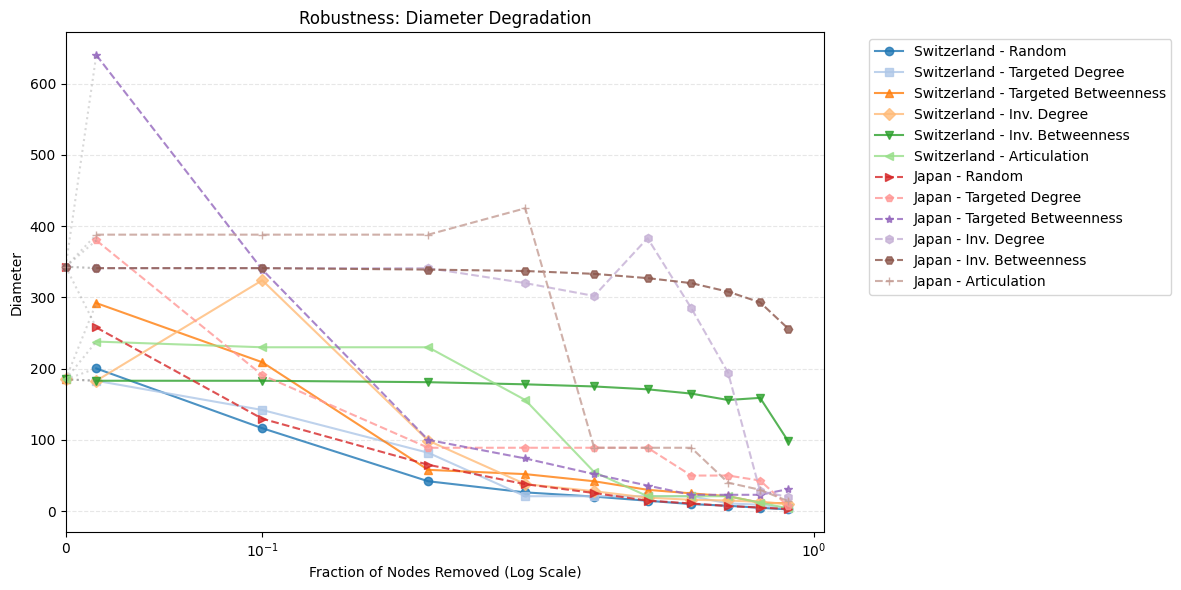


--- Robustness: Avg Path Length ---
NetworkVisualizer: CI environment detected. Generating static plot for GitHub compatibility.


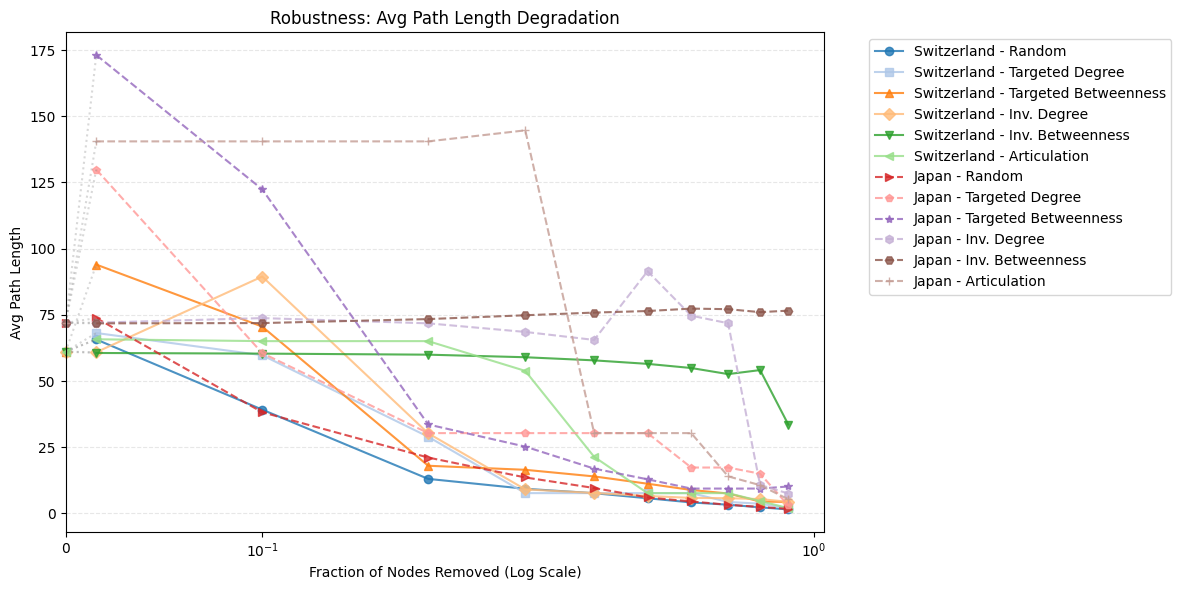

In [5]:
# 4. Consolidated Robustness Analysis (All Metrics)
# Visualizes robustness across all available metrics and strategies.
# One plot per metric, including Global Efficiency, LCC, etc.
from src.analysis.comparison import plot_all_metrics_consolidated

# Ensure results are loaded
if 'storage' in locals() and 'COUNTRIES' in locals():
    results_cache = {}
    for c in COUNTRIES:
        results_cache[c] = storage.load_results(c)

if 'viz' in locals() and 'results_cache' in locals():
    plot_all_metrics_consolidated(results_cache, viz, COUNTRIES)
else:
    print("Visualization or Results not available. Run previous cells.")

## 5. Network Maps Side-by-Side (Interactive)

In [6]:
# Interactive Side-by-Side Comparison
# Controls: Strategy Dropdown and Fraction Slider affect BOTH maps simultaneously.

ui = viz.compare_interactive_maps(
    graphs['switzerland'], 
    graphs['japan'], 
    name1="Switzerland", 
    name2="Japan"
)

if ui:
    display(ui)
else:
    print("Could not initialize interactive maps (missing coordinates?).")

Skipping comparison map in CI.
Could not initialize interactive maps (missing coordinates?).
